# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np
from torchinfo import summary  

# Load dataset

In [2]:
X_train = np.load('X_train.npy')
X_val = np.load('X_val.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')

In [3]:
#Print Dataset for Verification
print(f"X_train.shape: {X_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_val.shape: {y_val.shape}")
#Print Class Distribution
print(f"y_train class distribution: {np.bincount(y_train.astype(int))}")
print(f"y_val class distribution: {np.bincount(y_val.astype(int))}")

X_train.shape: (1587, 100, 9)
X_val.shape: (397, 100, 9)
y_train.shape: (1587,)
y_val.shape: (397,)
y_train class distribution: [1505   82]
y_val class distribution: [376  21]


# Apply Class Weight

In [4]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Adjust weight for positive class (reduce by 20%)
class_weight_dict[1] = class_weight_dict[1] * 0.8
print("Adjusted class weights:", class_weight_dict)

# Convert class weights to tensor
class_weights_tensor = torch.FloatTensor([class_weight_dict[0], class_weight_dict[1]])

Adjusted class weights: {0: 0.5272425249169436, 1: 7.741463414634147}


# Dataset + DataLoader

In [5]:
from torch.utils.data import Dataset, DataLoader

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values if hasattr(y, 'values') else y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_ds = TabularDataset(X_train, y_train)
val_ds = TabularDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights_tensor = class_weights_tensor.to(device)



# Model

In [6]:
class SAINTTransformer(nn.Module):
    def __init__(self, input_dim, embedding_dim=64, num_heads=4, num_layers=3, dropout=0.1, max_seq_len=100):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embedding_dim)

        # Learnable positional encoding
        self.pos_embedding = nn.Parameter(torch.randn(1, max_seq_len, embedding_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, 
            nhead=num_heads, 
            dropout=dropout, 
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Attention pooling layer
        self.attention_pool = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

        self.hidden = nn.Linear(embedding_dim, 32)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(32, 1)  # Binary classification

    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        B, T, _ = x.size()

        x = self.embedding(x)  # (B, T, embedding_dim)

        # Add positional encoding (trim to T)
        x = x + self.pos_embedding[:, :T, :]

        x = self.transformer(x)  # (B, T, embedding_dim)

        # Attention pooling
        attn_weights = self.attention_pool(x)  # (B, T, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)  # (B, T, 1)
        x = torch.sum(x * attn_weights, dim=1)  # (B, embedding_dim)

        x = self.relu(self.hidden(x))  # (B, 32)
        logits = self.classifier(x)    # (B, 1)
        return logits
    
n_features = X_train.shape[2]  # Get number of features from the data
model = SAINTTransformer(input_dim=n_features).to(device)
summary(model, input_size=(64, 100, n_features))

Layer (type:depth-idx)                        Output Shape              Param #
SAINTTransformer                              [64, 1]                   6,400
├─Linear: 1-1                                 [64, 100, 64]             640
├─TransformerEncoder: 1-2                     [64, 100, 64]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [64, 100, 64]             281,152
│    │    └─TransformerEncoderLayer: 3-2      [64, 100, 64]             281,152
│    │    └─TransformerEncoderLayer: 3-3      [64, 100, 64]             281,152
├─Sequential: 1-3                             [64, 100, 1]              --
│    └─Linear: 2-2                            [64, 100, 128]            8,320
│    └─Tanh: 2-3                              [64, 100, 128]            --
│    └─Linear: 2-4                            [64, 100, 1]              129
├─Linear: 1-4                                 [64, 32]                  

# Criterion (Loss Function) + Optimizer

In [7]:
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])  # Use pos_weight for binary classification
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Epochs & Record Best Train & Val Metrics

In [8]:
epochs = 20
best_val_auc = 0
best_val_cm = None
best_train_auc = 0
best_train_cm = None
best_train_prec = 0
best_train_rec = 0
best_train_f1 = 0

history = {
    'train_prec': [], 'val_prec': [],
    'train_rec': [], 'val_rec': [],
    'train_f1': [], 'val_f1': [],
    'train_auc': [], 'val_auc': [],
}

loss = {
    'train_loss': [], 'val_loss': [],
}

acc = {
    'train_acc': [], 'val_acc':[],
}

# Define Training Process & Evaluation Metrics

In [9]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, auc, roc_curve, precision_recall_curve, average_precision_score

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    all_probs = []
    all_preds = []
    all_targets = []

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(1), y_batch.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

        probs = torch.sigmoid(outputs).squeeze(dim=1).detach().cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_targets.extend(y_batch.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_auc = roc_auc_score(all_targets, all_probs)
    epoch_prec = precision_score(all_targets, all_preds)
    epoch_rec = recall_score(all_targets, all_preds)
    epoch_f1 = f1_score(all_targets, all_preds)
    epoch_acc = accuracy_score(all_targets, all_preds)
    epoch_cm = confusion_matrix(all_targets, all_preds)
    return epoch_loss, epoch_auc, epoch_acc, epoch_prec, epoch_rec, epoch_f1, epoch_cm, all_targets, all_probs

def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0
    all_probs = []
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(1), y_batch.float())
            running_loss += loss.item() * X_batch.size(0)

            probs = torch.sigmoid(outputs).squeeze(dim=1).detach().cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_targets.extend(y_batch.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_auc = roc_auc_score(all_targets, all_probs)
    epoch_prec = precision_score(all_targets, all_preds)
    epoch_rec = recall_score(all_targets, all_preds)
    epoch_f1 = f1_score(all_targets, all_preds)
    epoch_acc = accuracy_score(all_targets, all_preds)
    epoch_cm = confusion_matrix(all_targets, all_preds)
    return epoch_loss, epoch_auc, epoch_acc, epoch_prec, epoch_rec, epoch_f1, epoch_cm, all_targets, all_probs


# Start Training

In [10]:
for epoch in range(epochs):
        train_loss, train_auc, train_acc, train_prec, train_rec, train_f1, train_cm, train_all_targets, train_all_probs = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_auc, val_acc, val_prec, val_rec, val_f1, val_cm, all_targets, all_probs = eval_one_epoch(model, val_loader, criterion, device)

        history['train_prec'].append(train_prec)
        history['val_prec'].append(val_prec)

        history['train_rec'].append(train_rec)
        history['val_rec'].append(val_rec)

        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        history['train_auc'].append(train_auc)
        history['val_auc'].append(val_auc)

        loss['train_loss'].append(train_loss)
        loss['val_loss'].append(val_loss)

        acc['train_acc'].append(train_acc)
        acc['val_acc'].append(val_acc)

        # Track best validation
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_val_cm = val_cm
            best_val_prec = val_prec
            best_val_rec = val_rec
            best_val_f1 = val_f1
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_saint_model.pth')
            

        # Track best training
        if train_auc > best_train_auc:
            best_train_auc = train_auc
            best_train_cm = train_cm
            best_train_prec = train_prec
            best_train_rec = train_rec
            best_train_f1 = train_f1
            best_train_acc = train_acc

            best_train_targets = train_all_targets.copy()
            best_train_probs = train_all_probs.copy()

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f}, Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, Rec: {train_rec:.4f}, F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, AUC: {val_auc:.4f}, Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, Rec: {val_rec:.4f}, F1: {val_f1:.4f}")

Epoch 1/20 - Train Loss: 0.6639, AUC: 0.7913, Acc: 0.7580, Prec: 0.1225, Rec: 0.5976, F1: 0.2033
Val Loss: 0.5883, AUC: 0.7928, Acc: 0.7280, Prec: 0.1520, Rec: 0.9048, F1: 0.2603
Epoch 2/20 - Train Loss: 0.5579, AUC: 0.8081, Acc: 0.7234, Prec: 0.1493, Rec: 0.9268, F1: 0.2572
Val Loss: 0.5874, AUC: 0.7977, Acc: 0.7305, Prec: 0.1532, Rec: 0.9048, F1: 0.2621
Epoch 3/20 - Train Loss: 0.5614, AUC: 0.7993, Acc: 0.7284, Prec: 0.1503, Rec: 0.9146, F1: 0.2582
Val Loss: 0.5957, AUC: 0.8185, Acc: 0.7204, Prec: 0.1484, Rec: 0.9048, F1: 0.2550
Epoch 4/20 - Train Loss: 0.5570, AUC: 0.7901, Acc: 0.7234, Prec: 0.1493, Rec: 0.9268, F1: 0.2572
Val Loss: 0.5895, AUC: 0.8322, Acc: 0.7305, Prec: 0.1532, Rec: 0.9048, F1: 0.2621
Epoch 5/20 - Train Loss: 0.5891, AUC: 0.7999, Acc: 0.7353, Prec: 0.1494, Rec: 0.8780, F1: 0.2553
Val Loss: 0.5618, AUC: 0.8098, Acc: 0.7103, Prec: 0.1493, Rec: 0.9524, F1: 0.2581
Epoch 6/20 - Train Loss: 0.5807, AUC: 0.7934, Acc: 0.7064, Prec: 0.1431, Rec: 0.9390, F1: 0.2484
Val Loss

# Plot Metrics (AUC-ROC, Precision, Recall, F1)

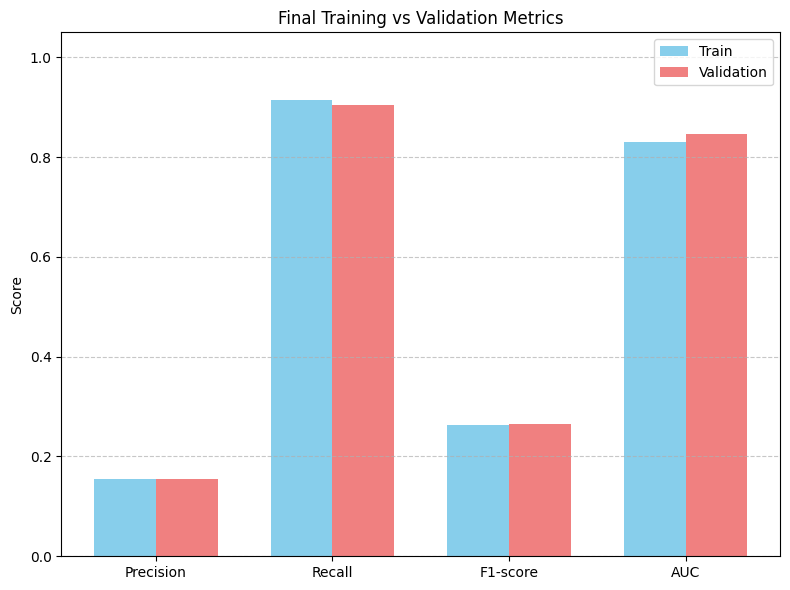

In [11]:
import matplotlib.pyplot as plt

def plot_metrics(history, filename):
    # Get final epoch metrics
    metrics = ['Precision', 'Recall', 'F1-score', 'AUC']
    train_scores = [
        best_train_prec,
        best_train_rec,
        best_train_f1,
        best_train_auc
    ]
    val_scores = [
        best_val_prec,
        best_val_rec,
        best_val_f1,
        best_val_auc
    ]

    x = np.arange(len(metrics))  # Metric categories
    width = 0.35  # Bar width

    plt.figure(figsize=(8, 6))
    plt.bar(x - width/2, train_scores, width, label='Train', color='skyblue')
    plt.bar(x + width/2, val_scores, width, label='Validation', color='lightcoral')

    plt.ylabel('Score')
    plt.ylim(0, 1.05)
    plt.title('Final Training vs Validation Metrics')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()

plot_metrics(history, 'training_validation_metrics.png')

# Plot Loss & Accuracy

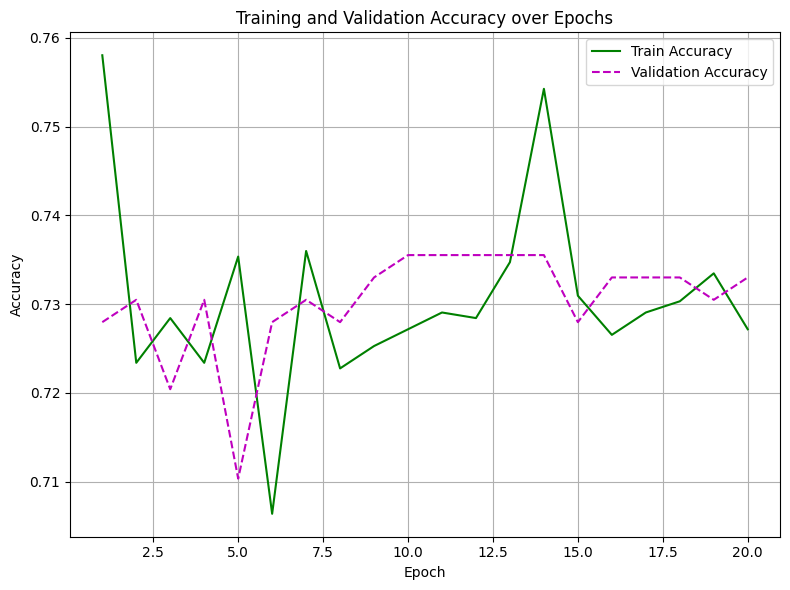

In [12]:
def plot_loss_and_accuracy(loss_history, acc_history, loss_filename, acc_filename):
    epochs = range(1, len(loss_history['train_loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(8,6))
    plt.plot(epochs, loss_history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, loss_history['val_loss'], 'r--', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(loss_filename)
    plt.close()

    # Plot Accuracy
    plt.figure(figsize=(8,6))
    plt.plot(epochs, acc_history['train_acc'], 'g-', label='Train Accuracy')
    plt.plot(epochs, acc_history['val_acc'], 'm--', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(acc_filename)
    plt.show()
    plt.close()
    
plot_loss_and_accuracy(loss, acc, 'training_validation_loss.png', 'training_validation_acc.png')


# Plot ROC Curve

Computed AUC inside plot function: 0.8388


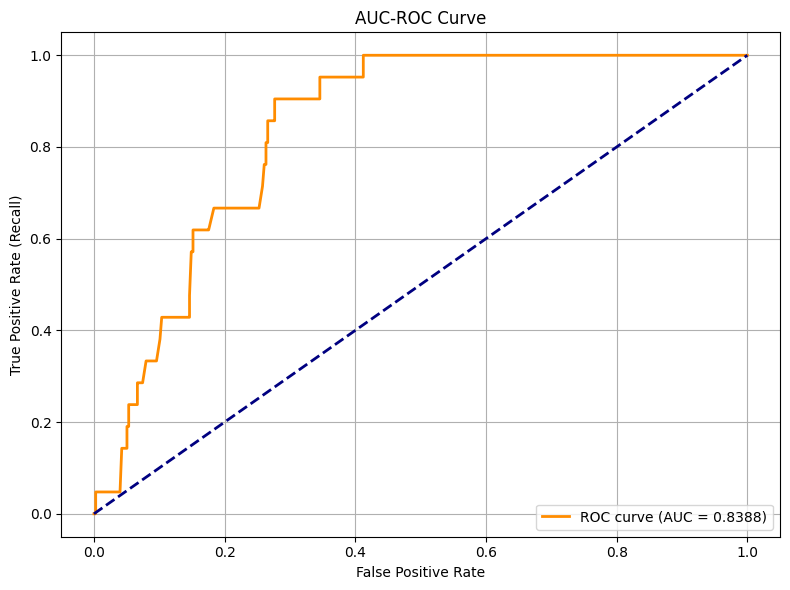

Computed AUC inside plot function: 0.8297


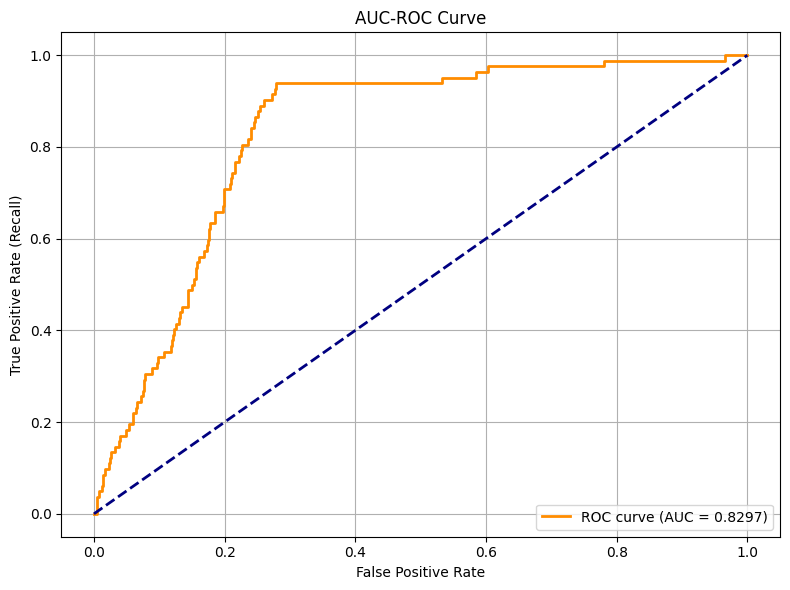

In [13]:
from sklearn.metrics import roc_auc_score

def plot_roc_curve(y_true, y_scores, filename):
    # Calculate AUC inside plot function to be sure
    roc_auc = roc_auc_score(y_true, y_scores)
    print(f"Computed AUC inside plot function: {roc_auc:.4f}")
    
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('AUC-ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()


plot_roc_curve(all_targets, all_probs, 'val_roc_curve.png')
plot_roc_curve(best_train_targets, best_train_probs, 'train_roc_curve.png')

# Plot Precision-Recall Curve

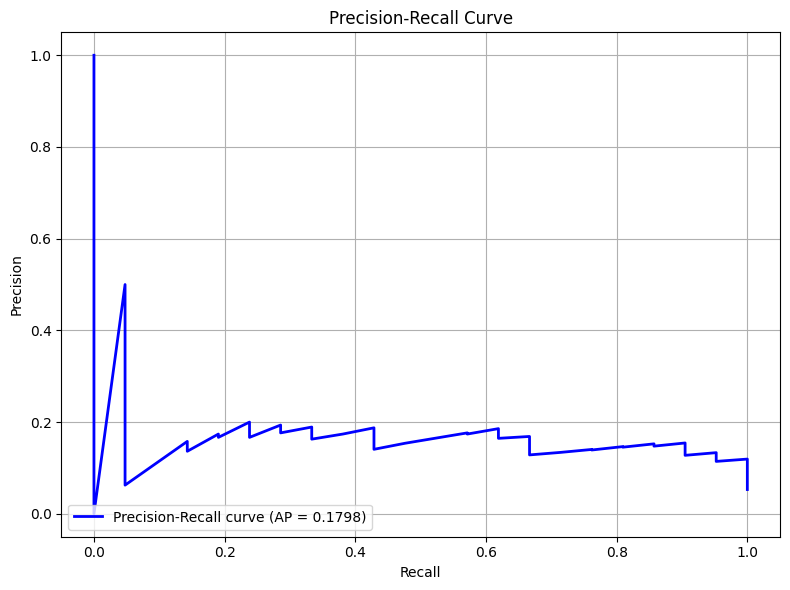

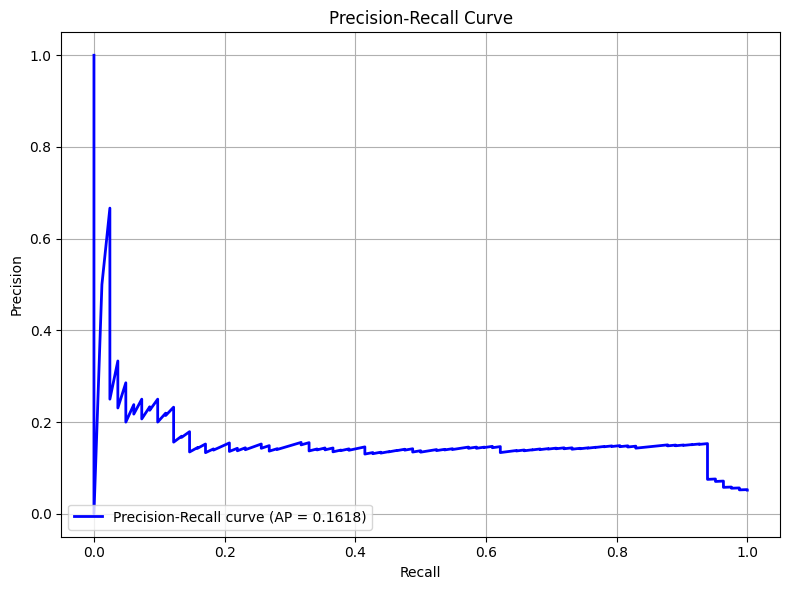

In [14]:
def plot_precision_recall_curve(y_true, y_scores, filename):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)
    
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()
    
plot_precision_recall_curve(all_targets, all_probs, 'val_precision_recall_curve.png')
plot_precision_recall_curve(train_all_targets, train_all_probs, 'train_precision_recall_curve.png')


# Print Best Evaluation Metrics (Training & Validation)


Best Training AUC: 0.8297
Best Training Precision: 0.1540
Best Training Recall: 0.9146
Best Training F1-score: 0.2636
Best Training Confusion Matrix:
[[1093  412]
 [   7   75]]


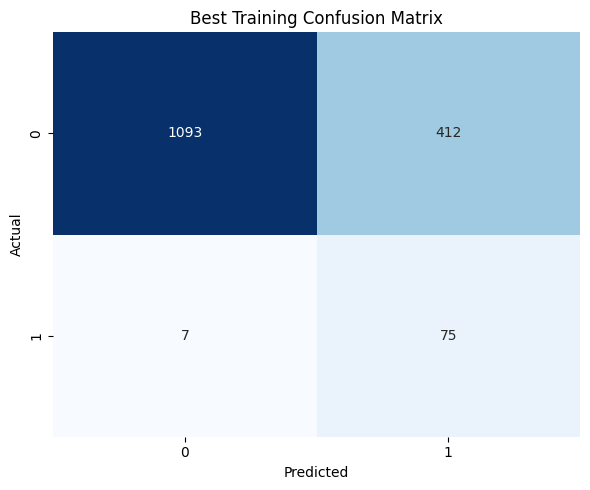


Best Validation AUC: 0.8466
Best Validation Precision: 0.1557
Best Validation Recall: 0.9048
Best Validation F1-score: 0.2657
Best Validation Confusion Matrix:
[[273 103]
 [  2  19]]


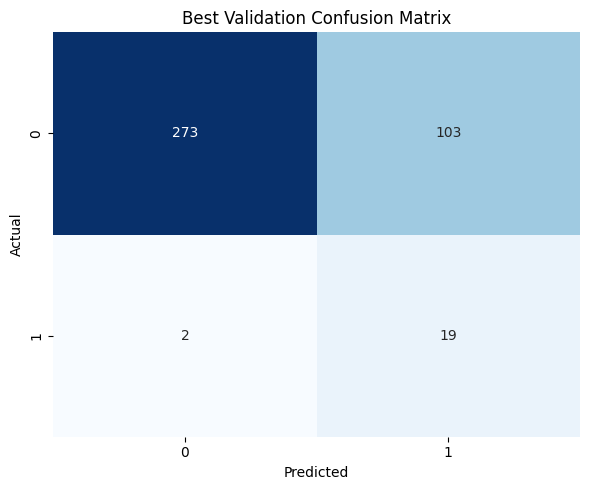

In [15]:
def plot_and_save_cm(cm, title, filename):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()
# Final metric printouts
# print(f"\nBest Training Accuracy: {best_train_acc:.4f}")
print(f"\nBest Training AUC: {best_train_auc:.4f}")
print(f"Best Training Precision: {best_train_prec:.4f}")
print(f"Best Training Recall: {best_train_rec:.4f}")
print(f"Best Training F1-score: {best_train_f1:.4f}")
print("Best Training Confusion Matrix:")
print(best_train_cm)
plot_and_save_cm(best_train_cm, 'Best Training Confusion Matrix', 'best_train_cm.png')

# print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")
print(f"\nBest Validation AUC: {best_val_auc:.4f}")
print(f"Best Validation Precision: {best_val_prec:.4f}")
print(f"Best Validation Recall: {best_val_rec:.4f}")
print(f"Best Validation F1-score: {best_val_f1:.4f}")
print("Best Validation Confusion Matrix:")
print(best_val_cm)
plot_and_save_cm(best_val_cm, 'Best Validation Confusion Matrix', 'best_val_cm.png')

# Make Predictions 

In [16]:
print("Loading test dataset...")
test_ids_full = pd.read_csv('test.csv')['bidder_id']

print("Loading preprocessed test data...")
X_test = np.load('X_test.npy')
bidder_ids_with_bids = np.load('bidders_ids.npy')  # Make sure you have this file
    
input_dim = X_test.shape[2]
print(f"Input sequence shape: {X_test.shape}")


Loading test dataset...
Loading preprocessed test data...


Input sequence shape: (4630, 100, 9)


# Load Model

In [17]:
def load_model(model_path='best_saint_model.pth', input_dim=7):
    model = SAINTTransformer(input_dim=input_dim)
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    return model, device
    
print("Loading model...")
model, device = load_model(input_dim=input_dim)


Loading model...


# Running Prediction

In [18]:
@torch.no_grad()
def predict(model, device, X):
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)  # shape: (batch, seq_len, input_dim)
    outputs = model(X_tensor)
    probs = torch.sigmoid(outputs).squeeze(dim=1).detach().cpu().numpy()
    return probs
    
print("Running predictions...")
probs = predict(model, device, X_test)

Running predictions...


# Save Result and Assign Default Low Robot Probability to those with no bids

In [19]:
# Confidence-based predictions
results = pd.DataFrame({
    'bidder_id': bidder_ids_with_bids,
    'prediction': probs
})

# Handle missing bidders (those with no bids)
missing_ids = set(test_ids_full) - set(results['bidder_id'])
print(f"Missing {len(missing_ids)} bidder_ids with no bids")

# Assign default low robot probability to those with no bids
default_prob = 0.5 #0.5 because we want to be conservative
missing_df = pd.DataFrame({
    'bidder_id': list(missing_ids),
    'prediction': default_prob
})

# Merge both
final_results = pd.concat([results, missing_df], ignore_index=True)
final_results = final_results.sort_values('bidder_id')

# Sanity check
assert final_results['prediction'].between(0, 1).all()
assert final_results['bidder_id'].nunique() == len(test_ids_full)

# Summary
print("\nPrediction Summary:")
print("=" * 30)
print(f"Total bidders in test set: {len(final_results)}")
print(f"Bidders with no bids (defaulted): {len(missing_ids)}")
print("=" * 30)

# Save to CSV
final_results.to_csv('Transformer_based.csv', index=False)
print("Submission saved as Transformer_based.csv")

Missing 70 bidder_ids with no bids

Prediction Summary:
Total bidders in test set: 4700
Bidders with no bids (defaulted): 70
Submission saved as Transformer_based.csv
